# Experiment with different classification algorithms

## Plan

Things to try

1. Advanced Ensemble Techniques
    - **Blending**: We’ll implement a blending technique where a meta-model is trained on a holdout set (a part of the training data not seen by the base models).
    - **Bagging**: We’ll explore bagging, which involves training multiple instances of the same model on different subsets of the training data.

2. Class Balancing Techniques
    - **ADASYN**: We’ll experiment with the ADASYN technique for generating synthetic samples to balance the classes.
    - **Class Weighting**: In some algorithms like Logistic Regression or SVM, we can assign weights to classes inversely proportional to their frequency.

3. Regularization
We’ll apply L1 or L2 regularization to models like Logistic Regression, SVM, or any other linear models used in your ensemble.

4.  Hyperparameter Tuning
We'll use grid search to find the best hyperparameters for the models.

5. Cross-Validation
We'll use cross-validation to validate the models' performance.

## Stacking methods

### Set up

In [19]:
import joblib
import matplotlib.pyplot as plt
import optuna
import pandas as pd
import seaborn as sns
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import VotingClassifier, RandomForestClassifier, GradientBoostingClassifier, StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import RandomizedSearchCV, train_test_split, StratifiedKFold, cross_val_score
from sklearn.neural_network import MLPClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.svm import SVC
from xgboost import XGBClassifier


# Load the train data
train_path = r"../data/clean/test.parquet"
data_train = pd.read_parquet(train_path)

# test data
test_path = r"../data/clean/test.parquet"
data_test = pd.read_parquet(test_path)

# stack the data
data = pd.concat([data_train, data_test])

## Preparation

### Split data

In [20]:
# Separate features and target
y = data.pop('Y')
X = data
# Handle imbalanced data
smote = SMOTE(random_state=42)
X_res, y_res = smote.fit_resample(X, y)

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, test_size=0.2, random_state=42, stratify=y_res)

Let's keep on improving our data pipelines

### Voting Classifier

In [21]:
# Define the models with pipelines
pipelines = {
    'LogisticRegression': Pipeline([
        ('scaler', StandardScaler()),
        ('clf', LogisticRegression(max_iter=1000, random_state=42))
    ]),
    'RandomForest': Pipeline([
        ('clf', RandomForestClassifier(random_state=42))
    ]),
    'SVM': Pipeline([
        ('scaler', StandardScaler()),
        ('clf', SVC(random_state=42))
    ]),
    'GradientBoosting': Pipeline([
        ('clf', GradientBoostingClassifier(random_state=42))
    ]),
    'XGBoost': Pipeline([
        ('clf', XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss'))
    ])
}

# Train and evaluate each model
results = {}
for name, pipeline in pipelines.items():
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred)
    results[name] = (accuracy, report)

# Print results
for model_name, (accuracy, report) in results.items():
    print(f"Model: {model_name}")
    print(f"Accuracy: {accuracy}")
    print("Classification Report:")
    print(report)
    print("="*60)

Model: LogisticRegression
Accuracy: 0.8333333333333334
Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.83      0.83         6
           1       0.83      0.83      0.83         6

    accuracy                           0.83        12
   macro avg       0.83      0.83      0.83        12
weighted avg       0.83      0.83      0.83        12

Model: RandomForest
Accuracy: 1.0
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         6
           1       1.00      1.00      1.00         6

    accuracy                           1.00        12
   macro avg       1.00      1.00      1.00        12
weighted avg       1.00      1.00      1.00        12

Model: SVM
Accuracy: 0.8333333333333334
Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.83      0.83         6
           1       0.83      0.83      

In [22]:
# Hyperparameter Tuning using RandomizedSearchCV
tuning_params = {
    'RandomForest': {
        'clf__n_estimators': [50, 100, 200],
        'clf__max_depth': [None, 10, 20, 30],
        'clf__min_samples_split': [2, 5, 10],
        'clf__min_samples_leaf': [1, 2, 4]
    },
    'GradientBoosting': {
        'clf__n_estimators': [50, 100, 200],
        'clf__learning_rate': [0.01, 0.1, 0.2],
        'clf__max_depth': [3, 5, 7]
    },
    'SVM': {
        'clf__C': [0.1, 1, 10],
        'clf__kernel': ['linear', 'rbf']
    },
    'LogisticRegression': {
        'clf__C': [0.1, 1, 10],
        'clf__solver': ['liblinear', 'lbfgs']
    },
    'XGBoost': {
        'clf__n_estimators': [50, 100, 200],
        'clf__learning_rate': [0.01, 0.1, 0.2],
        'clf__max_depth': [3, 5, 7]
    }
}

best_models = {}
for name, pipeline in pipelines.items():
    print(f"Tuning hyperparameters for {name}...")
    random_search = RandomizedSearchCV(estimator=pipeline, param_distributions=tuning_params[name], n_iter=20, cv=5, n_jobs=-1, verbose=2, random_state=42)
    random_search.fit(X_train, y_train)
    best_models[name] = random_search.best_estimator_

# Evaluate the best models
for name, best_model in best_models.items():
    y_pred = best_model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred)
    print(f"Best {name} Model")
    print(f"Accuracy: {accuracy}")
    print("Classification Report:")
    print(report)
    print("Best Parameters:", best_model.get_params())
    print("="*60)

# Cross-Validation for the best models
for name, best_model in best_models.items():
    cv_scores = cross_val_score(best_model, X_res, y_res, cv=StratifiedKFold(5), verbose=0)
    print(f"Cross-Validation Accuracy for {name}: {cv_scores.mean()} ± {cv_scores.std()}")

# Ensemble Model - Voting Classifier
voting_clf = VotingClassifier(estimators=[
    ('lr', best_models['LogisticRegression']),
    ('rf', best_models['RandomForest']),
    ('svm', best_models['SVM']),
    ('gb', best_models['GradientBoosting']),
    ('xgb', best_models['XGBoost'])
], voting='hard')

voting_clf.fit(X_train, y_train)
y_pred = voting_clf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)
print(f"Voting Classifier Model")
print(f"Accuracy: {accuracy}")
print("Classification Report:")
print(report)

# Cross-Validation for Voting Classifier
cv_scores = cross_val_score(voting_clf, X_res, y_res, cv=StratifiedKFold(5))
print(f"Cross-Validation Accuracy for Voting Classifier: {cv_scores.mean()} ± {cv_scores.std()}")

# Save the best models and voting classifier
date_time = pd.Timestamp.now().strftime('%Y-%m-%d_%H-%M-%S')

for name, best_model in best_models.items():
    joblib.dump(best_model, f'../models/{date_time}/best_{name}_model.pkl')
joblib.dump(voting_clf, f'../models/{date_time}/best_voting_classifier_.pkl')

Tuning hyperparameters for LogisticRegression...
Fitting 5 folds for each of 6 candidates, totalling 30 fits
Tuning hyperparameters for RandomForest...
Fitting 5 folds for each of 20 candidates, totalling 100 fits


c:\Users\Guill\miniconda3\envs\happy-ml\lib\site-packages\sklearn\model_selection\_search.py:320: UserWarning: The total space of parameters 6 is smaller than n_iter=20. Running 6 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Tuning hyperparameters for SVM...
Fitting 5 folds for each of 6 candidates, totalling 30 fits
Tuning hyperparameters for GradientBoosting...
Fitting 5 folds for each of 20 candidates, totalling 100 fits


c:\Users\Guill\miniconda3\envs\happy-ml\lib\site-packages\sklearn\model_selection\_search.py:320: UserWarning: The total space of parameters 6 is smaller than n_iter=20. Running 6 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Tuning hyperparameters for XGBoost...
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best LogisticRegression Model
Accuracy: 0.75
Classification Report:
              precision    recall  f1-score   support

           0       0.80      0.67      0.73         6
           1       0.71      0.83      0.77         6

    accuracy                           0.75        12
   macro avg       0.76      0.75      0.75        12
weighted avg       0.76      0.75      0.75        12

Best Parameters: {'memory': None, 'steps': [('scaler', StandardScaler()), ('clf', LogisticRegression(C=0.1, max_iter=1000, random_state=42))], 'verbose': False, 'scaler': StandardScaler(), 'clf': LogisticRegression(C=0.1, max_iter=1000, random_state=42), 'scaler__copy': True, 'scaler__with_mean': True, 'scaler__with_std': True, 'clf__C': 0.1, 'clf__class_weight': None, 'clf__dual': False, 'clf__fit_intercept': True, 'clf__intercept_scaling': 1, 'clf__l1_ratio': None, 'clf__max_iter': 1000, 'clf__mult

['best_voting_classifier_{date_time}.pkl']

### Voting with Optuna

[I 2024-08-20 08:55:46,453] A new study created in memory with name: no-name-b64d72ad-03dd-418f-8a98-4450b23783a7
[I 2024-08-20 08:55:47,299] Trial 0 finished with value: 0.7977777777777777 and parameters: {'n_estimators': 117, 'max_depth': 12, 'min_samples_split': 7, 'min_samples_leaf': 3}. Best is trial 0 with value: 0.7977777777777777.
[I 2024-08-20 08:55:48,071] Trial 1 finished with value: 0.8800000000000001 and parameters: {'n_estimators': 101, 'max_depth': 24, 'min_samples_split': 5, 'min_samples_leaf': 1}. Best is trial 1 with value: 0.8800000000000001.
[I 2024-08-20 08:55:49,131] Trial 2 finished with value: 0.7955555555555555 and parameters: {'n_estimators': 153, 'max_depth': 30, 'min_samples_split': 9, 'min_samples_leaf': 2}. Best is trial 1 with value: 0.8800000000000001.
[I 2024-08-20 08:55:49,581] Trial 3 finished with value: 0.8177777777777777 and parameters: {'n_estimators': 63, 'max_depth': 12, 'min_samples_split': 6, 'min_samples_leaf': 3}. Best is trial 1 with value:

Best RandomForest Model with Optuna
Accuracy: 1.0
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         6
           1       1.00      1.00      1.00         6

    accuracy                           1.00        12
   macro avg       1.00      1.00      1.00        12
weighted avg       1.00      1.00      1.00        12

Voting Classifier Model
Accuracy: 1.0
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         6
           1       1.00      1.00      1.00         6

    accuracy                           1.00        12
   macro avg       1.00      1.00      1.00        12
weighted avg       1.00      1.00      1.00        12

Cross-Validation Accuracy for Voting Classifier: 1.0 ± 0.0


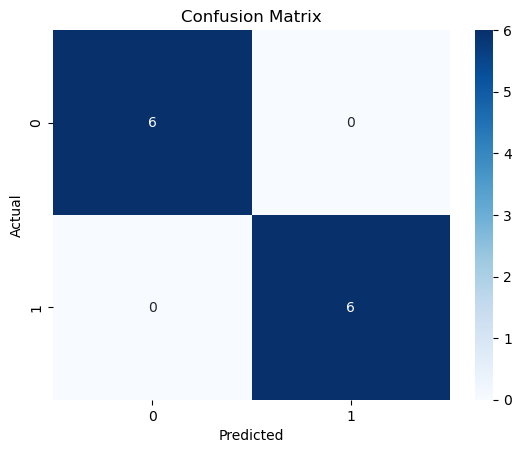

['best_voting_classifier_2024-08-20_08-56-23.pkl']

In [23]:
# Hyperparameter tuning using Optuna for an example model (Random Forest)
def objective(trial):
    param_grid = {
        'n_estimators': trial.suggest_int('n_estimators', 50, 200),
        'max_depth': trial.suggest_int('max_depth', 10, 30),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 10),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 4),
    }

    pipeline = Pipeline([
        ('clf', RandomForestClassifier(random_state=42, **param_grid))
    ])

    return cross_val_score(
        pipeline, X_train, y_train, cv=StratifiedKFold(5), verbose=0
        ).mean()


study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50)
best_params = study.best_params

# Train and evaluate the best RandomForest model with optimized hyperparameters
best_rf_pipeline = Pipeline([
    ('clf', RandomForestClassifier(random_state=42, **best_params))
])
best_rf_pipeline.fit(X_train, y_train)
y_pred = best_rf_pipeline.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)
print("Best RandomForest Model with Optuna")
print(f"Accuracy: {accuracy}")
print("Classification Report:")
print(report)

# Evaluate the ensemble model (Voting Classifier)
voting_clf = VotingClassifier(estimators=[
    ('lr', pipelines['LogisticRegression']),
    ('rf', pipelines['RandomForest']),
    ('svm', pipelines['SVM']),
    ('gb', pipelines['GradientBoosting']),
    ('xgb', pipelines['XGBoost'])
], voting='hard')

voting_clf.fit(X_train, y_train)
y_pred = voting_clf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)
print("Voting Classifier Model")
print(f"Accuracy: {accuracy}")
print("Classification Report:")
print(report)

# Cross-Validation for Voting Classifier
cv_scores = cross_val_score(voting_clf, X_res, y_res, cv=StratifiedKFold(5))
print(f"Cross-Validation Accuracy for Voting Classifier: {cv_scores.mean()} ± {cv_scores.std()}")

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# Save the best models and voting classifier
date_time = pd.Timestamp.now().strftime('%Y-%m-%d_%H-%M-%S')

for name, best_model in best_models.items():
    joblib.dump(best_model, f'../models/{date_time}/best_{name}_model.pkl')
joblib.dump(voting_clf, f'../models/{date_time}/best_voting_classifier.pkl')

## Implementation of Stacking:

### StackingClassifier
+ polynomial features

c:\Users\Guill\miniconda3\envs\happy-ml\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\Guill\miniconda3\envs\happy-ml\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\Guill\miniconda3\envs\happy-ml\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\Guill\miniconda3\envs\happy-ml\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\Gui

Stacking Classifier Model
Accuracy: 1.0
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         6
           1       1.00      1.00      1.00         6

    accuracy                           1.00        12
   macro avg       1.00      1.00      1.00        12
weighted avg       1.00      1.00      1.00        12



c:\Users\Guill\miniconda3\envs\happy-ml\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\Guill\miniconda3\envs\happy-ml\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\Guill\miniconda3\envs\happy-ml\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\Guill\miniconda3\envs\happy-ml\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\Gui

Cross-Validation Accuracy for Stacking Classifier: 1.0 ± 0.0


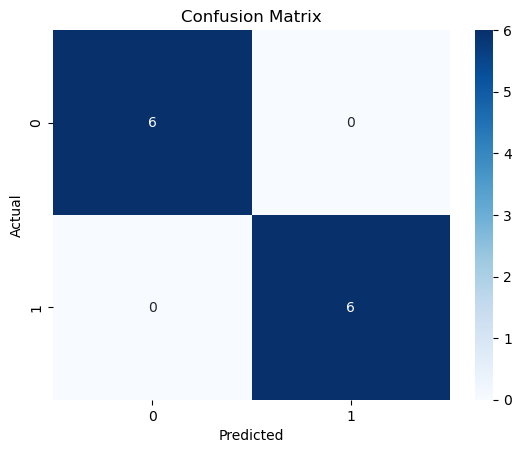

['../models/stacking_classifier_2024-08-20_08-56-23.pkl']

In [24]:
# Define the base models with pipelines
base_models = [
    ('lr', Pipeline([('scaler', StandardScaler()), ('clf', LogisticRegression(max_iter=1000, random_state=42))])),
    ('rf', Pipeline([('clf', RandomForestClassifier(random_state=42))])),
    ('svm', Pipeline([('scaler', StandardScaler()), ('clf', SVC(random_state=42))])),
    ('gb', Pipeline([('clf', GradientBoostingClassifier(random_state=42))])),
    ('xgb', Pipeline([('clf', XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss'))])),
    ('mlp', Pipeline([('scaler', StandardScaler()), ('clf', MLPClassifier(random_state=42, max_iter=500))]))
]

# Define the meta-model with polynomial features
meta_model = Pipeline([
    ('poly', PolynomialFeatures(degree=2, interaction_only=True)),
    ('scaler', StandardScaler()),
    ('clf', RandomForestClassifier(random_state=42))
])

# Stacking Classifier
stacking_clf = StackingClassifier(estimators=base_models, final_estimator=meta_model, cv=5)

# Train and evaluate the stacking classifier
stacking_clf.fit(X_train, y_train)
y_pred = stacking_clf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

print(f"Stacking Classifier Model")
print(f"Accuracy: {accuracy}")
print("Classification Report:")
print(report)

# Cross-Validation for Stacking Classifier
cv_scores = cross_val_score(stacking_clf, X_res, y_res, cv=StratifiedKFold(5))
print(f"Cross-Validation Accuracy for Stacking Classifier: {cv_scores.mean()} ± {cv_scores.std()}")

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# Save the stacking classifier
joblib.dump(stacking_clf, f'../models/stacking_classifier_{date_time}.pkl')

### Stacking 3
* Polynomial features
+ Optuna

[I 2024-08-20 08:56:45,097] A new study created in memory with name: no-name-783e5559-981a-4518-a72f-05b77fa4542e
C:\Users\Guill\AppData\Local\Temp\ipykernel_42352\3569166741.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'C': trial.suggest_loguniform('C', 1e-5, 1e2),
[I 2024-08-20 08:56:45,863] Trial 0 finished with value: 0.96 and parameters: {'C': 0.002665869956770616, 'penalty': 'l2', 'solver': 'lbfgs'}. Best is trial 0 with value: 0.96.
C:\Users\Guill\AppData\Local\Temp\ipykernel_42352\3569166741.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'C': trial.suggest_loguniform('C', 1e-5, 1e2),
[I 2024-08-20 08:56:46,628] Trial 1 finished with value: 0.96 and p

Stacking Classifier with Optimized Base Models
Accuracy: 1.0
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         6
           1       1.00      1.00      1.00         6

    accuracy                           1.00        12
   macro avg       1.00      1.00      1.00        12
weighted avg       1.00      1.00      1.00        12

Cross-Validation Accuracy for Stacking Classifier: 1.0 ± 0.0


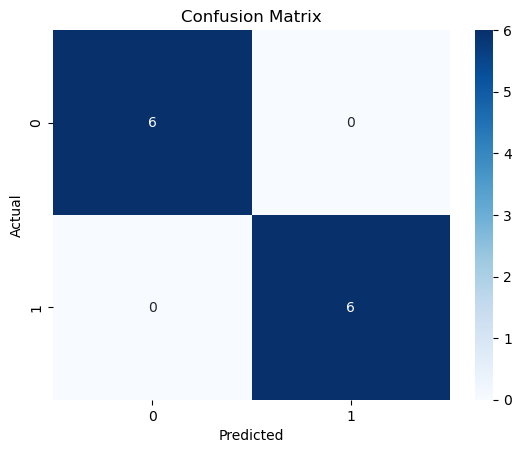

['../models/stacking_classifier_optimized_2024-08-20_08-59-28.pkl']

In [25]:
# Define the objective functions for each base model
def objective_lr(trial):
    param_grid = {
        'C': trial.suggest_loguniform('C', 1e-5, 1e2),
        'penalty': trial.suggest_categorical('penalty', ['l2']),
        'solver': trial.suggest_categorical('solver', ['lbfgs']),
    }
    pipeline = Pipeline([
        ('poly', PolynomialFeatures(degree=2, interaction_only=True)),
        ('scaler', StandardScaler()),
        ('clf', RandomForestClassifier(random_state=42))
    ])
    return cross_val_score(pipeline, X_train, y_train, cv=StratifiedKFold(5)).mean()

def objective_rf(trial):
    param_grid = {
        'n_estimators': trial.suggest_int('n_estimators', 50, 200),
        'max_depth': trial.suggest_int('max_depth', 10, 30),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 10),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 4),
    }
    pipeline = Pipeline([
        ('clf', RandomForestClassifier(random_state=42, **param_grid))
    ])
    return cross_val_score(pipeline, X_train, y_train, cv=StratifiedKFold(5)).mean()

def objective_svm(trial):
    param_grid = {
        'C': trial.suggest_loguniform('C', 1e-3, 1e2),
        'kernel': trial.suggest_categorical('kernel', ['linear', 'rbf']),
    }
    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('clf', SVC(random_state=42, **param_grid))
    ])
    return cross_val_score(pipeline, X_train, y_train, cv=StratifiedKFold(5)).mean()

def objective_gb(trial):
    param_grid = {
        'n_estimators': trial.suggest_int('n_estimators', 50, 200),
        'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 1e-1),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
    }
    pipeline = Pipeline([
        ('clf', GradientBoostingClassifier(random_state=42, **param_grid))
    ])
    return cross_val_score(pipeline, X_train, y_train, cv=StratifiedKFold(5)).mean()

def objective_xgb(trial):
    param_grid = {
        'n_estimators': trial.suggest_int('n_estimators', 50, 200),
        'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 1e-1),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
    }
    pipeline = Pipeline([
        ('clf', XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss', **param_grid))
    ])
    return cross_val_score(pipeline, X_train, y_train, cv=StratifiedKFold(5)).mean()

# Run Optuna studies for each base model
studies = {}
for model_name, objective in zip(
    ['LogisticRegression', 'RandomForest', 'SVM', 'GradientBoosting', 'XGBoost'],
    [objective_lr, objective_rf, objective_svm, objective_gb, objective_xgb]
):
    study = optuna.create_study(direction='maximize')
    study.optimize(objective, n_trials=50)
    studies[model_name] = study.best_params

# Define the optimized base models
optimized_base_models = [
    ('lr', Pipeline([('scaler', StandardScaler()), ('clf', LogisticRegression(max_iter=1000, random_state=42, **studies['LogisticRegression']))])),
    ('rf', Pipeline([('clf', RandomForestClassifier(random_state=42, **studies['RandomForest']))])),
    ('svm', Pipeline([('scaler', StandardScaler()), ('clf', SVC(random_state=42, **studies['SVM']))])),
    ('gb', Pipeline([('clf', GradientBoostingClassifier(random_state=42, **studies['GradientBoosting']))])),
    ('xgb', Pipeline([('clf', XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss', **studies['XGBoost']))]))
]

# Define the meta-model
meta_model = Pipeline([
    ('scaler', StandardScaler()),
    ('clf', LogisticRegression(max_iter=1000, random_state=42))
])

# Stacking Classifier with optimized base models
stacking_clf = StackingClassifier(estimators=optimized_base_models, final_estimator=meta_model, cv=5)

# Train and evaluate the stacking classifier
stacking_clf.fit(X_train, y_train)
y_pred = stacking_clf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

print(f"Stacking Classifier with Optimized Base Models")
print(f"Accuracy: {accuracy}")
print("Classification Report:")
print(report)

# Cross-Validation for Stacking Classifier
cv_scores = cross_val_score(stacking_clf, X_res, y_res, cv=StratifiedKFold(5))
print(f"Cross-Validation Accuracy for Stacking Classifier: {cv_scores.mean()} ± {cv_scores.std()}")

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# Save the stacking classifier
date_time = pd.Timestamp.now().strftime('%Y-%m-%d_%H-%M-%S')
joblib.dump(stacking_clf, f'../models/stacking_classifier_optimized_{date_time}.pkl')

# Winner

c:\Users\Guill\miniconda3\envs\happy-ml\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\Guill\miniconda3\envs\happy-ml\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\Guill\miniconda3\envs\happy-ml\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\Guill\miniconda3\envs\happy-ml\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\Gui

Stacking Classifier Model
Accuracy: 1.0
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         6
           1       1.00      1.00      1.00         6

    accuracy                           1.00        12
   macro avg       1.00      1.00      1.00        12
weighted avg       1.00      1.00      1.00        12



c:\Users\Guill\miniconda3\envs\happy-ml\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\Guill\miniconda3\envs\happy-ml\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\Guill\miniconda3\envs\happy-ml\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\Guill\miniconda3\envs\happy-ml\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\Gui

Cross-Validation Accuracy for Stacking Classifier: 1.0 ± 0.0


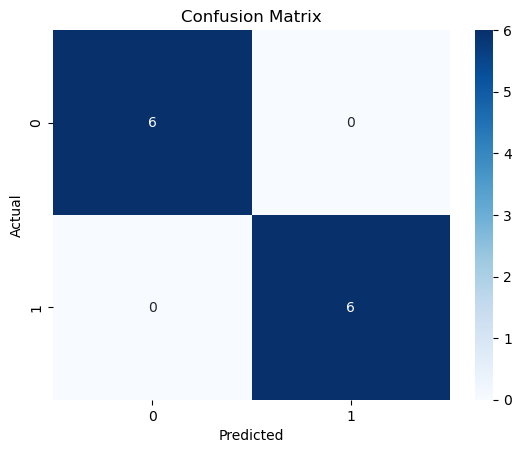

['stacking_classifier.pkl']

In [26]:
# Load the data
base_models = [
    ('lr', Pipeline([('scaler', StandardScaler()), ('clf', LogisticRegression(max_iter=1000, random_state=42))])),
    ('rf', Pipeline([('clf', RandomForestClassifier(random_state=42))])),
    ('svm', Pipeline([('scaler', StandardScaler()), ('clf', SVC(random_state=42))])),
    ('gb', Pipeline([('clf', GradientBoostingClassifier(random_state=42))])),
    ('xgb', Pipeline([('clf', XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss'))])),
    ('mlp', Pipeline([('scaler', StandardScaler()), ('clf', MLPClassifier(random_state=42, max_iter=500))]))
]

# Define the meta-model with polynomial features
meta_model = Pipeline([
    ('poly', PolynomialFeatures(degree=2, interaction_only=True)),
    ('scaler', StandardScaler()),
    ('clf', RandomForestClassifier(random_state=42))
])

# Stacking Classifier
stacking_clf = StackingClassifier(estimators=base_models, final_estimator=meta_model, cv=5)

# Train and evaluate the stacking classifier
stacking_clf.fit(X_train, y_train)
y_pred = stacking_clf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

print(f"Stacking Classifier Model")
print(f"Accuracy: {accuracy}")
print("Classification Report:")
print(report)

# Cross-Validation for Stacking Classifier
cv_scores = cross_val_score(stacking_clf, X_res, y_res, cv=StratifiedKFold(5))
print(f"Cross-Validation Accuracy for Stacking Classifier: {cv_scores.mean()} ± {cv_scores.std()}")

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# Save the stacking classifier
joblib.dump(stacking_clf, 'stacking_classifier.pkl')